In [2]:
from proxmin import nmf
from proxmin.utils import Traceback
from scipy.optimize import linear_sum_assignment
from scipy.stats import binned_statistic
import numpy as np
import matplotlib.pyplot as plt
import time
from proxmin import operators as po
from functools import partial

In [4]:
data = np.load("hsc_stacked.npy")

redshifts = np.array([item[0] for item in data])

# Bin the cluster data by redshift
cluster1 = data[(redshifts > 0.1) & (redshifts < 0.2)]
cluster2 = data[(redshifts > 0.2) & (redshifts < 0.35)]
cluster3 = data[(redshifts > 0.35) & (redshifts < 0.5)]
cluster4 = data[(redshifts > 0.5) & (redshifts < 0.75)]
cluster5 = data[(redshifts > 0.75) & (redshifts < 1.2)]

In [115]:
# Compute the average colors for the first redshift bin

radii_1 = np.array([item[1] for item in cluster1])
num_bins_1 = 20
radial_bins_1 = np.logspace(np.log10(0.0319), np.log10(5.), num_bins_1)
widths_1 = np.diff(radial_bins_1)

# Arrays containing magnitude data in four different filters
g_1 = np.array([item[2] for item in cluster1])
r_1 = np.array([item[3] for item in cluster1])
i_1 = np.array([item[4] for item in cluster1])
z_1 = np.array([item[5] for item in cluster1])

# For each color g-r, r-i, and i-z: first, throw out data points that have magnitudes of "nan" or "inf" (pruning the
# arrays of radii and magnitudes accordingly), then use scipy.binned_statistic to sort the data into radial bins and
# compute the mean and variance (noise^2) of the color values in those bins

radii_1_gr_pruned = radii_1[np.isfinite(g_1) & np.isfinite(r_1)]
gr_1 = g_1[np.isfinite(g_1) & np.isfinite(r_1)] - r_1[np.isfinite(g_1) & np.isfinite(r_1)]
mean_gr_1 = binned_statistic(radii_1_gr_pruned, gr_1, 'mean', radial_bins_1)[0]
var_gr_1 = binned_statistic(radii_1_gr_pruned, gr_1, np.var, radial_bins_1)[0]

radii_1_ri_pruned = radii_1[np.isfinite(r_1) & np.isfinite(i_1)]
ri_1 = r_1[np.isfinite(r_1) & np.isfinite(i_1)] - i_1[np.isfinite(r_1) & np.isfinite(i_1)]
mean_ri_1 = binned_statistic(radii_1_ri_pruned, ri_1, 'mean', radial_bins_1)[0]
var_ri_1 = binned_statistic(radii_1_ri_pruned, ri_1, np.var, radial_bins_1)[0]

radii_1_iz_pruned = radii_1[np.isfinite(i_1) & np.isfinite(z_1)]
iz_1 = i_1[np.isfinite(i_1) & np.isfinite(z_1)] - z_1[np.isfinite(i_1) & np.isfinite(z_1)]
mean_iz_1 = binned_statistic(radii_1_iz_pruned, iz_1, 'mean', radial_bins_1)[0]
var_iz_1 = binned_statistic(radii_1_iz_pruned, iz_1, np.var, radial_bins_1)[0]

# Compute the mean and variance of the i magnitudes over the same radial bins as above
radii_1_i_pruned = radii_1[np.isfinite(i_1)]
mean_i_1 = binned_statistic(radii_1_i_pruned, i_1, 'mean', radial_bins_1)[0]
var_i_1 = binned_statistic(radii_1_i_pruned, i_1, np.var, radial_bins_1)[0]

0.0319214067145 4.99999999701


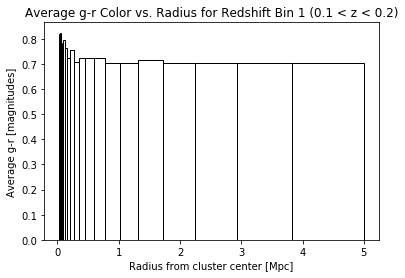

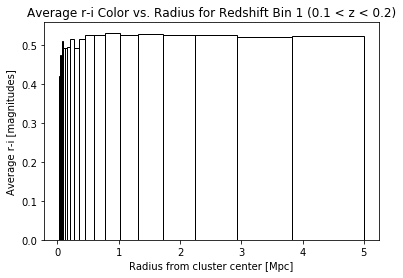

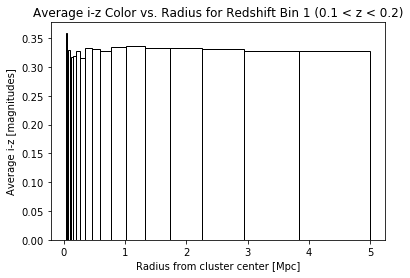

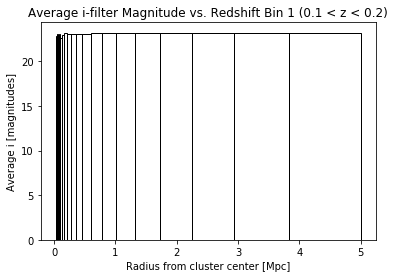

In [114]:
#Plot bar graphs for the cluster1 data

plt.bar(radial_bins_1[:-1], mean_gr_1, width=widths_1, fill=False, align="edge")#, yerr=np.sqrt(var_gr_1))
plt.title("Average g-r Color vs. Radius for Redshift Bin 1 (0.1 < z < 0.2)")
plt.xlabel("Radius from cluster center [Mpc]")
plt.ylabel ("Average g-r [magnitudes]")
plt.show()

plt.bar(radial_bins_1[:-1], mean_ri_1, width=widths_1, fill=False, align="edge")#, yerr=np.sqrt(var_ri_1))
plt.title("Average r-i Color vs. Radius for Redshift Bin 1 (0.1 < z < 0.2)")
plt.xlabel("Radius from cluster center [Mpc]")
plt.ylabel ("Average r-i [magnitudes]")
plt.show()

plt.bar(radial_bins_1[:-1], mean_iz_1, width=widths_1, fill=False, align="edge")#, yerr=np.sqrt(var_iz_1))
plt.title("Average i-z Color vs. Radius for Redshift Bin 1 (0.1 < z < 0.2)")
plt.xlabel("Radius from cluster center [Mpc]")
plt.ylabel ("Average i-z [magnitudes]")
plt.show()

plt.bar(radial_bins_1[:-1], mean_i_1, width=widths_1, fill=False, align="edge")#, yerr=np.sqrt(var_i_1))
plt.title("Average i-filter Magnitude vs. Redshift Bin 1 (0.1 < z < 0.2)")
plt.xlabel("Radius from cluster center [Mpc]")
plt.ylabel ("Average i [magnitudes]")
plt.show()

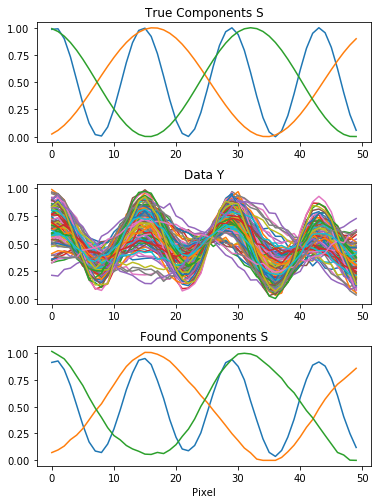

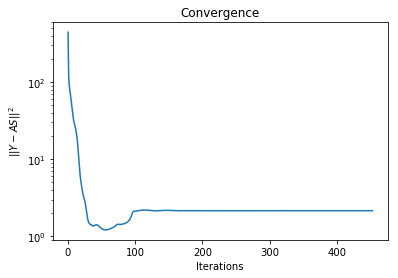

In [1]:
def match(A, S, trueS):
    """Rearranges columns of S to best fit the components they likely represent (maximizes sum of correlations)"""
    cov = np.cov(trueS, S)
    k = S.shape[0]
    corr = np.zeros([k,k])
    for i in range(k):
        for j in range(k):
            corr[i][j] = cov[i + k][j]/np.sqrt(cov[i + k][i + k]*cov[j][j])
    arrangement = linear_sum_assignment(-corr)
    resS = np.zeros_like(S)
    resAT = np.zeros_like(A.T)
    for t in range(k):
        resS[arrangement[1][t]] = S[arrangement[0][t]]
        resAT[arrangement[1][t]] = A.T[arrangement[0][t]]
    return resAT.T, resS

if __name__ == "__main__":
    n = num_bins_1          # component resolution
    k = 3                   # number of components
    b = 4                   # number of observations (b=4 for g-r, r-i, i-z, and i)
    #noise = 0.02           # stdev of added noise

    # Data matrix to be unmixed
    Y = np.array([mean_gr_1, mean_ri_1, mean_iz_1, mean_i_1])
    
    # if noise is variable, specify variance matrix of the same shape as Y
    W = np.array([var_gr_1, var_ri_1, var_iz_1, var_i_1])

    # initialize and run NMF
    A = np.array([generateAmplitudes(k) for i in range(b)]) #???
    S = np.array([generateComponent(n) for i in range(k)])  #???
    p1 = partial(po.prox_unity_plus, axis=1)
    proxs_g=[[p1], None]
    tr = Traceback(2)
    nmf(Y, A, S, W=W, prox_A=p1, e_rel=1e-6, e_abs=1e-6/noise**2, traceback=tr)
    # sort components to best match inputs
    A, S = match(A, S, trueS)

    # show data and model
    fig = plt.figure(figsize=(6,7))
    ax = fig.add_subplot(311)
    ax.set_title("True Components S")
    ax.plot(trueS.T)
    ax2 = fig.add_subplot(312)
    ax2.set_title("Data Y")
    ax2.plot(Y.T)
    ax3 = fig.add_subplot(313)
    ax3.set_title("Found Components S")
    ax3.set_xlabel("Pixel")
    ax3.plot(S.T)
    fig.subplots_adjust(bottom=0.07, top=0.95, hspace=0.35)
    plt.show()

    # convergence plot from traceback
    #convergences = []
    #As = tr['X',0]
    #Ss = tr['X',1]
    #for it in range(tr.it):
    #    Y = np.dot(As[it], Ss[it])
    #    convergences.append(((Y - trueY)**2).sum())
    #fig2 = plt.figure(figsize=(6,4))
    #ax4 = fig2.add_subplot(111)
    #ax4.set_title("Convergence")
    #ax4.semilogy(convergences)
    #ax4.set_ylabel("$||Y-AS||^2$")
    #ax4.set_xlabel("Iterations")
    #plt.show()
